In [ ]:
!pip install xlrd

In [9]:
import sys
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from shapely.geometry import Point
from shapely.geometry import Polygon

<AxesSubplot:>

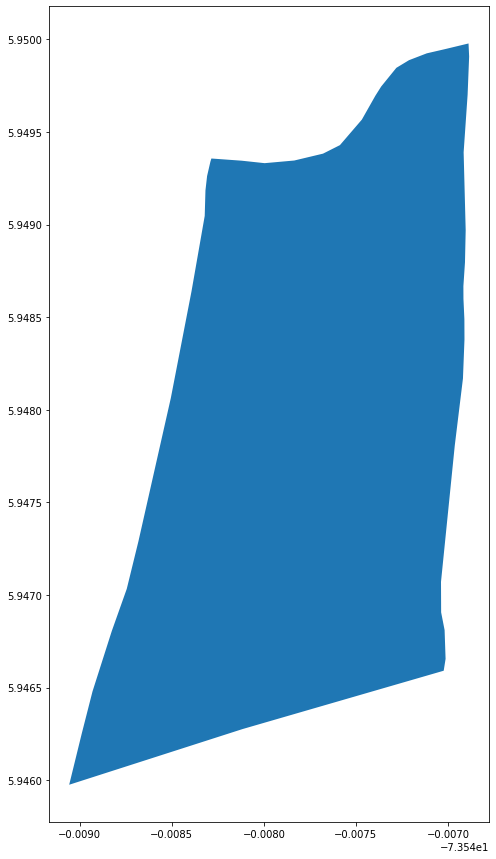

In [10]:
geo_df = gpd.read_file('shape_predios/01_SIA_ASG_51300/predio1/r_terreno.shp')
fig, ax = plt.subplots(figsize=(15,15))
geo_df.plot(ax=ax)

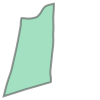

In [11]:
predio_1_geometry = geo_df['geometry'][0]
predio_1_geometry

In [12]:
minx, miny, maxx, maxy = predio_1_geometry.bounds

buffer = 0.001

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

study_area_lat = (miny,maxy)
study_area_lon = (minx,maxx)

print('lat:',study_area_lat)
print('lon:',study_area_lon)

lat: (5.944975351000072, 5.950978061000025)
lon: (-73.55005675999999, -73.54588549399998)


In [17]:
# Set the data source - s2a corresponds to Sentinel-2A
set_product = "s2_sen2cor_ard_granule_EO3"

# Set the date range to load data over
# set_time = ("2018-01-01", "2020-12-31")
set_time = ("2020-02-01", "2020-02-28")

# Set the measurements/bands to load
# For this analysis, we'll load the red, green, blue and near-infrared bands
set_measurements = [
    "red",
    "blue",
    "green",
    "scl"
]

# Set the coordinate reference system and output resolution
# set_crs = 'EPSG:32719'
set_crs = 'EPSG:32719'

# set_resolution = (-30, 30)
set_resolution =(-10,10)

In [18]:
%%time

dc = datacube.Datacube(app="Cana")

dataset = dc.load(
    product=set_product,
    longitude=study_area_lon,
    latitude=study_area_lat,
    time=set_time,
    measurements=set_measurements,
    #crs=set_crs,
    output_crs=set_crs,
    resolution=set_resolution,
#     dask_chunks={"time": 1}
)

CPU times: user 4.72 s, sys: 1.94 s, total: 6.66 s
Wall time: 2.54 s


In [19]:
dataset

<xarray.Dataset>
Dimensions:      (time: 10, x: 48, y: 68)
Coordinates:
  * time         (time) datetime64[ns] 2020-02-03T19:33:08 ... 2020-02-28T19:...
  * y            (y) float64 1.066e+07 1.066e+07 ... 1.066e+07 1.066e+07
  * x            (x) float64 -4.125e+03 -4.115e+03 ... -3.665e+03 -3.655e+03
    spatial_ref  int32 32719
Data variables:
    red          (time, y, x) uint16 357 336 318 292 272 ... 7876 8104 8256 8448
    blue         (time, y, x) uint16 220 168 181 177 222 ... 8760 9000 9176 9032
    green        (time, y, x) uint16 442 375 432 422 457 ... 8392 8648 8864 8840
    scl          (time, y, x) uint8 4 4 4 4 4 4 4 4 4 4 ... 9 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

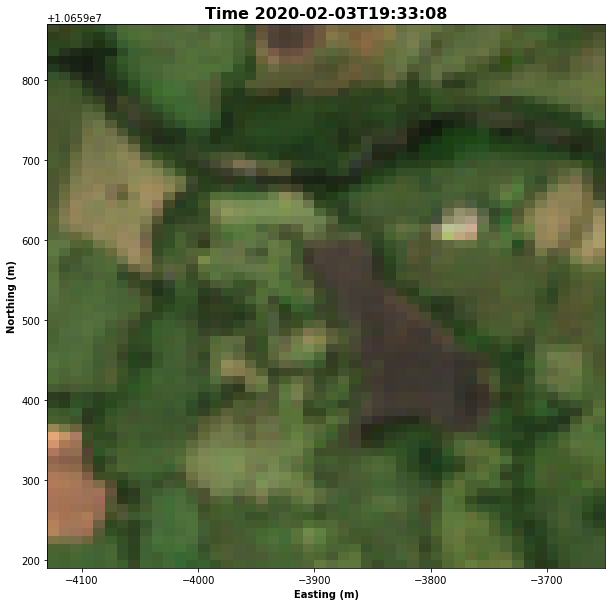

In [22]:
### Set the time step to view
time_index = 0

# Set the band combination to plot
bands = ["red", "green", "blue"]

# Format the time stamp for use as the plot title
time_string = str(dataset.time.isel(time=time_index).values).split('.')[0]  

dataset[bands].isel(time=time_index).to_array().plot.imshow(vmin=0,vmax=1500,figsize=(10,10))

# Set the title and axis labels
ax = plt.gca()

# geo_df_point.plot(ax=ax,markersize=20,color='red',marker='o')

ax.set_title(f"Time {time_string}", fontweight='bold', fontsize=16)
ax.set_xlabel('Easting (m)', fontweight='bold')
ax.set_ylabel('Northing (m)', fontweight='bold')

# Display the plot
plt.show()

In [23]:
# VALORES VALIDOS PARA ANALISIS PRESENTES EN 
# LA BANDA PIXEL_QA

# Para este caso únicamente nos interesa conservar 
# aquellos pixeles cuya obvercación es clara y 
# además pixeles que pueden mostrar información 
# acerca del agua

valid_values = [4, 5, 6]

# Aquellos pixeles cuyos valor esten en valid_values tendran un
# valor de True en la corrspondiente posición en la matrix mask_1 
# indicando que son pixeles validos para analisis. Aquellos pixeles 
# cuyos valores no esten en valid_values tendran un valor de False 
# en mask_1.
mask_1 = np.isin(dataset.scl[0].values, valid_values)

# Calculo porcentaje de valores válidos
number_of_valid_values = np.count_nonzero(mask_1)
number_of_values_in_array = np.prod(mask_1.shape)

(number_of_valid_values/number_of_values_in_array)*100

96.32352941176471

In [24]:
dataset.time

<xarray.DataArray 'time' (time: 10)>
array(['2020-02-03T19:33:08.000000000', '2020-02-05T19:18:02.000000000',
       '2020-02-08T19:28:10.000000000', '2020-02-10T19:18:15.000000000',
       '2020-02-13T19:39:47.000000000', '2020-02-15T17:33:30.000000000',
       '2020-02-18T19:37:33.000000000', '2020-02-20T20:58:16.000000000',
       '2020-02-25T17:34:54.000000000', '2020-02-28T19:36:30.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2020-02-03T19:33:08 ... 2020-02-28T19:...
    spatial_ref  int32 32719
Attributes:
    units:    seconds since 1970-01-01 00:00:00

In [25]:
def cloud_precentage_period(shape_path,period,valid_values,buffer=0.001):

    geo_df = gpd.read_file(shape_path)
    
    predio_1_geometry = geo_df['geometry'][0]
    
    minx, miny, maxx, maxy = predio_1_geometry.bounds

    minx = minx - buffer
    miny = miny - buffer
    maxx = maxx + buffer
    maxy = maxy + buffer

    # Datacube Search Params
    study_area_lat = (miny,maxy)
    study_area_lon = (minx,maxx)

    # Set the data source - s2a corresponds to Sentinel-2A
    set_product = "s2_sen2cor_ard_granule_EO3"

    # Set the date range to load data over
    # set_time = ("2018-01-01", "2020-12-31")
    set_time = period

    # Set the measurements/bands to load
    # For this analysis, we'll load the red, green, blue and near-infrared bands
    set_measurements = [
        "red",
        "blue",
        "green",
        "scl"
    ]

    # Set the coordinate reference system and output resolution
    # set_crs = 'EPSG:32719'
    set_crs = 'EPSG:32719'

    # set_resolution = (-30, 30)
    set_resolution =(-10,10)
    
    dc = datacube.Datacube(app="Cloud")

    dataset = dc.load(
        product=set_product,
        longitude=study_area_lon,
        latitude=study_area_lat,
        time=set_time,
        measurements=set_measurements,
        #crs=set_crs,
        output_crs=set_crs,
        resolution=set_resolution,
    )
    
    percentage = 0
    for i, date_time in enumerate(dataset.time):
        
        mask_1 = np.isin(dataset.scl[i].values, valid_values)

        # Percentage of valid values
        number_of_valid_values = np.count_nonzero(mask_1)
        number_of_values_in_array = np.prod(mask_1.shape)

        percentage += (number_of_valid_values / number_of_values_in_array) * 100
    
    percentage_by_month = percentage / len(dataset.time)
    
    return percentage_by_month

In [26]:
# clear = [322, 386, 834, 898, 1346]
# water = [324, 388, 836, 900, 1348]
valid_values = [4, 5, 7]

cloud_precentage_period(
    shape_path='shape_predios/01_SIA_ASG_51300/predio1/r_terreno.shp',
    period=('2020-02-01', '2020-02-28'),
    valid_values=valid_values,
    buffer=0.001
)

41.95772058823529

## Análisis en 2020

In [27]:
%%time 

periods = [
#     ('Enero',     ('2020-01-01', '2020-01-31')),
    ('Febrero',   ('2020-02-01', '2020-02-28')),
    ('Marzo',     ('2020-03-01', '2020-03-31')),
    ('Abril',     ('2020-04-01', '2020-04-30')),
    ('Mayo',      ('2020-05-01', '2020-05-31')),
    ('Junio',     ('2020-06-01', '2020-06-30')),
    ('Julio',     ('2020-07-01', '2020-07-31')),
    ('Agosto',    ('2020-08-01', '2020-08-31')),
    ('Septiembre',('2020-09-01', '2020-09-30')),
#     ('Octubre',   ('2020-10-01', '2020-10-31')),
#     ('Noviembre', ('2020-11-01', '2020-11-30')),
#     ('Diciembre', ('2020-12-01', '2020-12-31')),    
]

months = []
percentages = []
for month, time_range in periods:
    months.append(month)
    percentage = cloud_precentage_period(
        shape_path='shape_predios/01_SIA_ASG_51300/predio1/r_terreno.shp',
        period=time_range,
        valid_values=valid_values,
        buffer=0.001
    )
    percentages.append(percentage)

print('Months',months)
print('Percentages', percentages)
print('Percentage AVG', sum(percentages)/len(percentages))

Months ['Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre']
Percentages [41.95772058823529, 44.2569073083779, 40.11693218954249, 24.89276960784314, 29.981617647058822, 10.15625, 56.61764705882353, 49.877450980392155]
Percentage AVG 37.23216192253417
CPU times: user 35.4 s, sys: 13.9 s, total: 49.3 s
Wall time: 17.6 s


In [28]:
df_clouds_percentage = pd.DataFrame(data={'percentage':percentages},index=months)
df_clouds_percentage

,percentage
Febrero,41.957721
Marzo,44.256907
Abril,40.116932
Mayo,24.892770
Junio,29.981618
Julio,10.156250
Agosto,56.617647
Septiembre,49.877451


<AxesSubplot:>

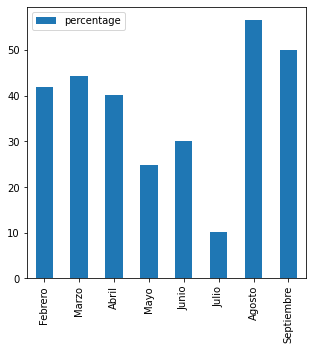

In [29]:
df_clouds_percentage.plot.bar(figsize=(5,5))

In [ ]:
df_clouds_percentage.to_csv(path_or_buf='2020.csv', sep=';')

## Análisis en 2019

In [ ]:
%%time 

periods = [
#     ('Enero',     ('2019-01-01', '2019-01-31')),
#     ('Febrero',   ('2019-02-01', '2019-02-28')),
#     ('Marzo',     ('2019-03-01', '2019-03-31')),
#     ('Abril',     ('2019-04-01', '2019-04-30')),
    ('Mayo',      ('2019-05-01', '2019-05-31')),
    ('Junio',     ('2019-06-01', '2019-06-30')),
    ('Julio',     ('2019-07-01', '2019-07-31')),
    ('Agosto',    ('2019-08-01', '2019-08-31')),
    ('Septiembre',('2019-09-01', '2019-09-30')),
    ('Octubre',   ('2019-10-01', '2019-10-31')),
    ('Noviembre', ('2019-11-01', '2019-11-30')),
    ('Diciembre', ('2019-12-01', '2019-12-31')),    
]

months = []
percentages = []
for month, time_range in periods:
    months.append(month)
    percentage = cloud_precentage_period(
        shape_path='shape_predios/01_SIA_ASG_51300/predio1/r_terreno.shp',
        period=time_range,
        valid_values=valid_values,
        buffer=0.001
    )
    percentages.append(percentage)

print('Months',months)
print('Percentages', percentages)
print('Percentage AVG', sum(percentages)/len(percentages))

In [ ]:
df_clouds_percentage = pd.DataFrame(data={'percentage':percentages},index=months)
df_clouds_percentage

In [ ]:
df_clouds_percentage.plot.bar(figsize=(5,5))

In [ ]:
df_clouds_percentage.to_csv(path_or_buf='2019.csv', sep=';')